In [1]:
from tespy.networks import Network
from tespy.connections import Connection
from tespy.components import (CycleCloser, Compressor, Valve, HeatExchangerSimple, Source, Sink)
import pandas as pd
import numpy as np

# constants:  
gpm_to_kgs = 0.0630901964 
users = 294
ns_per_s = 1e9
gpm_m3s = 0.0000630901964

In [2]:
# Importing flow values : 

SitesData = pd.read_csv("../data/site_d.csv")
SitesData['TimeStamp'] = pd.to_datetime(SitesData['TimeStamp'])
assert not SitesData.duplicated(subset=['TimeStamp']).any()
SitesData.set_index('TimeStamp', inplace=True)
SitesData = SitesData.tz_localize('UTC')
SitesData.sort_index(inplace=True)
SitesData = SitesData.resample('30s').mean()
flow_gpm = SitesData['FT1_GPM']
flow_is_nan = flow_gpm.isnull()
flow_gpm.fillna(0., inplace=True)
flow_gpm[flow_gpm < 0] = 0.
flow_m3s = flow_gpm * gpm_m3s
flow_per_user_m3s = flow_m3s / users
flow_per_user_m3s_rolling_mean = flow_per_user_m3s.rolling(600, min_periods=1).mean()
flow_time_s = flow_per_user_m3s_rolling_mean.index.astype(int).values / ns_per_s
flow_values_m3s = flow_per_user_m3s_rolling_mean.resample('1d').sum()

cwt_celsius = 5 / 9 * (SitesData['CWT'] - 32)
cwt_celsius[cwt_celsius < 0.] = 0.
cwt_values_celsius = cwt_celsius.resample('1d').median()
cwt_values_celsius = cwt_values_celsius.fillna(cwt_celsius.mean())

In [3]:
# Importing temperature values

Palestine_TX = pd.read_csv("../data/DFW.csv")
Palestine_TX['tmpc'] = Palestine_TX['tmpc'].replace('M', np.nan).replace('T', np.nan).astype(float)
Palestine_TX['timestamp_utc'] = pd.to_datetime(Palestine_TX['valid'])
assert not Palestine_TX.duplicated(subset=['timestamp_utc']).any()
Palestine_TX = Palestine_TX.set_index('timestamp_utc').tz_localize('UTC')
ambient_temp_c = Palestine_TX['tmpc']

In [4]:
# Matching time stamps:
air_temp = ambient_temp_c[(ambient_temp_c.index >= flow_per_user_m3s_rolling_mean.index.min()) 
                    & ((ambient_temp_c.index <= flow_per_user_m3s_rolling_mean.index.max()))]

In [5]:
# Cleaning Air temperature dataset: 

air_temp[air_temp < -10] = np.nan  # replace values below -10 such as -999 to NaN 
mean = air_temp.mean()
air_temp.fillna(mean, inplace=True)  # fill NaN values with the mean
air_temp[air_temp > 50] = np.nan   # replace values above 50 to NaN, erroneous and unreasonable values.
air_temp.fillna(mean, inplace=True)

In [6]:
# Run this line in the case of simulating daily outputs. In the case of 5min simulations, change air_temp and flow to 5min
air_temp = air_temp.resample('1d').mean().fillna(air_temp.mean())

In [7]:
# Q - heat demand (W)

c_p = 4184    #J/kg K
delta_t = (60 - cwt_values_celsius)  # K 
density = 1000 #kg/m3

Q_array = flow_values_m3s*c_p*delta_t*density
Q_array[Q_array == 0] = Q_array.mean()
Q_array = pd.DataFrame(Q_array)
Q_array = Q_array.values

In [8]:
# %%[sec_1]
from tespy.networks import Network
from tespy.components import (
    CycleCloser, Compressor, Valve, HeatExchangerSimple
)
from tespy.connections import Connection


# create a network object with R134a as fluid
fluid_list = ['R134a']
my_plant = Network(fluids=fluid_list)
my_plant.set_attr(T_unit='C', p_unit='bar', h_unit='J / kg')


# Components: 
cc = CycleCloser('cycle closer')
# heat sink
co = HeatExchangerSimple('condenser')
# heat source
ev = HeatExchangerSimple('evaporator')
va = Valve('expansion valve')
cp = Compressor('compressor')

# connections of heat pump
c1 = Connection(cc, 'out1', ev, 'in1', label='1')
c2 = Connection(ev, 'out1', cp, 'in1', label='2')
c3 = Connection(cp, 'out1', co, 'in1', label='3')
c4 = Connection(co, 'out1', va, 'in1', label='4')
c0 = Connection(va, 'out1', cc, 'in1', label='0')

# Add all connections to your network
my_plant.add_conns(c1, c2, c3, c4, c0)


#  Set attributes for components and connections: 
co.set_attr(pr=0.98, Q=-4e2)
ev.set_attr(pr=0.98)
cp.set_attr(eta_s=0.75)
c2.set_attr(T=20, x=1, fluid={'R134a': 1})
c4.set_attr(T=60, x=0)


# Solve the model created above (output is suppressed)
my_plant.solve(mode='design')

iter	| residual | massflow | pressure | enthalpy | fluid
--------+----------+----------+----------+----------+---------
1	| 4.95e+05 | 3.47e+01 | 2.77e+06 | 5.04e+05 | 0.00e+00
2	| 1.94e+06 | 3.45e+01 | 7.64e+05 | 2.74e+05 | 0.00e+00
3	| 1.97e+05 | 2.99e+00 | 7.23e+04 | 3.46e+03 | 0.00e+00
4	| 3.45e+03 | 5.07e-02 | 5.02e+02 | 2.40e+01 | 0.00e+00
5	| 2.48e-01 | 3.63e-06 | 1.27e-01 | 3.18e-03 | 0.00e+00
6	| 4.26e-06 | 6.51e-12 | 8.73e-03 | 4.37e-04 | 0.00e+00
--------+----------+----------+----------+----------+---------
Total iterations: 6, Calculation time: 0.0 s, Iterations per second: 272.18


In [9]:
# Iterate through air temperature, heat demand values to calculate COP.

import matplotlib.pyplot as plt
from contextlib import contextmanager
import sys, os

COP = np.zeros([len(Q_array),1])
for i in range(0,len(Q_array)):
    co.set_attr(pr=0.98, Q=-Q_array[i])
    c2.set_attr(T = air_temp[i]-8)
    @contextmanager
    def suppress_stdout():
        with open(os.devnull, "w") as devnull:
            old_stdout = sys.stdout
            sys.stdout = devnull
            try:  
                yield
            finally:
                sys.stdout = old_stdout
    with suppress_stdout():
        my_plant.solve('design')
        COP[i] = [abs(co.Q.val) / cp.P.val]
    

In [10]:
COP = pd.DataFrame(COP)
COP.columns = ['COP']

In [11]:
COP.index = air_temp.index

In [12]:
COP.mean()

COP    4.288498
dtype: float64

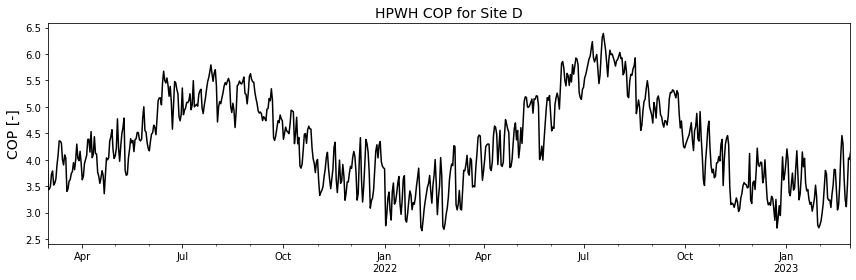

In [13]:
fig, ax = plt.subplots(figsize=(12, 4))
COP.plot(ax=ax, c='k', legend=None)
plt.title('HPWH COP for Site D', size=14)
plt.ylabel('COP [-]', size=14)
ax.set_xlim('2021-03-01', '2023-02-28')
ax.set_xlabel('')
plt.tight_layout()
plt.savefig('../img/COP_site_d.png', dpi=200, bbox_inches='tight')

In [14]:
COP.to_csv('../data/site_d_COP_1d.csv')